In [37]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL1G(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('P')
    return r + (iL,)

def read_other():
    etl1_o = np.zeros([48, 1445, 63, 64], dtype=np.uint8) # 48 other characters, 1445 writers, img size = 63*64
    label1_o=np.zeros([48, 1445],dtype=np.uint16)
    for i in range(0,6):
        filename = 'ETL1/ETL1C_{:02d}'.format(i+1)
        with open(filename, 'rb') as f: # file 13 only has 3 characters, others have 8 characters
            if i!=12: limit = 8
            else: limit=3
            for dataset in range(limit):
                for j in range(1445):
                    try :
                        r = read_record_ETL1G(f)
                        etl1_o[i* 8 + dataset, j] = np.array(r[-1])
                        label1_o[i* 8 + dataset, j]=r[3]
                    except struct.error: # two imgs are blank according to the ETL website, so this prevents any errors
                        pass
    np.savez_compressed("etl1_o.npz", etl1_o)
    np.savez_compressed("label1_o.npz", label1_o)
    

read_other()

def read_katakana():
    etl1_k = np.zeros([51, 1411, 63, 64], dtype=np.uint8) # 51 katakana characters, 1411 writers, img size = 63*64
    label1_k=np.zeros([51, 1411],dtype=np.uint16)
    for i in range(6,13):
        filename = 'ETL1/ETL1C_{:02d}'.format(i+1)
        with open(filename, 'rb') as f: # file 13 only has 3 characters, others have 8 characters
            if i!=12: limit = 8
            else: limit=3
            for dataset in range(limit):
                for j in range(1411):
                    try :
                        r = read_record_ETL1G(f)
                        etl1_k[(i-6)* 8 + dataset, j] = np.array(r[-1])
                        label1_k[(i-6)* 8 + dataset, j]=r[3]
                    except struct.error: # two imgs are blank according to the ETL website, so this prevents any errors
                        pass
    np.savez_compressed("etl1_k.npz", etl1_k)
    np.savez_compressed("label1_k.npz", label1_k)
    

read_katakana()

In [1]:
import numpy as np
etl1_k = np.load("etl1_k.npz")['arr_0'].astype(np.float32)
label1_k= np.load("label1_k.npz")['arr_0'].astype(np.uint16)
etl1_o = np.load("etl1_o.npz")['arr_0'].astype(np.float32)
label1_o= np.load("label1_o.npz")['arr_0'].astype(np.uint16)

In [2]:
etl1_k=etl1_k[:,:160]#only 160 writers
label1_k=label1_k[:,:160]

etl1_o=etl1_o[:,:160]#only 160 writers
label1_o=label1_o[:,:160]

etl1=np.concatenate((etl1_o, etl1_k), axis=0)
label1=np.concatenate((label1_o, label1_k), axis=0)

In [7]:
import skimage.transform
import numpy as np
import cv2
etl=etl1.reshape([-1,63,64])
label=label1.reshape([-1,1])
etl=etl.astype("uint8")
#etl= (etl/np.max(etl))
train_images = np.zeros([99 * 160, 48, 48], dtype=np.float32)

for i in range(99 * 160): # change the image size to 48*48
    etl[i]=etl[i].astype("uint8")
    #etl[i]=cv2.GaussianBlur(etl[i],(3,3),0)#
    etl[i]=cv2.threshold(etl[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]#
    #kernel=np.ones((2,2),np.uint8)#
    #etl[i]=cv2.erode(etl[i], kernel, iterations=2)#
    train_images[i] = skimage.transform.resize(etl[i], (48, 48))
    

In [9]:
np.savez_compressed("etl1.npz", train_images)
np.savez_compressed("labels1.npz", label)

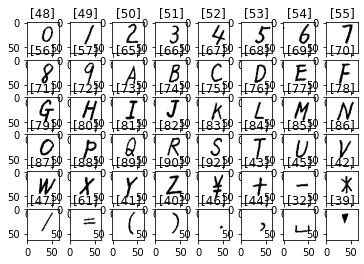

In [8]:
import matplotlib.pyplot as plt
for i in range(48):
    plt.subplot(6,8,i+1)
    plt.imshow(etl[i*160], cmap=plt.cm.binary)
    plt.title(label[i*160])
plt.show()
